In [22]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли
from sklearn import tree

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [23]:
# !pip install -U scikit-learn
# %conda install -c intel scikit-learn

### Предсказать совершение покупки пользователем во время его сессии на сайте некоторого интернет-магазина.

### Необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации.

In [24]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [25]:
# Посмотрим на размер таблицы:
print(shoppers_data.shape)

# В нашей таблице содержится информация о более чем 12 тысячах сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

(12330, 18)


In [26]:
# Заранее удостоверимся в отсутствии пропусков:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [27]:
# Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


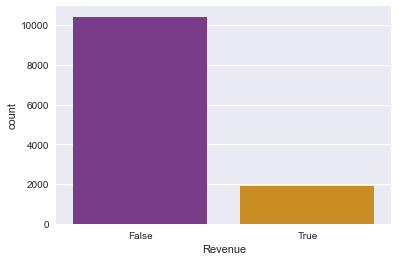

In [28]:
# посмотрим на соотношение классов в данных:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

#### Условимся, что лучшей будет считаться та модель, у которой значение метрики F1 для пользователей, совершивших покупку, будет наибольшим.

In [29]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Заранее определимся, как будем производить контроль качества моделей:

* Разделим выборку на тренировочную и тестовую.
* Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Будем использовать три показателя:

* значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
* значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
* Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

In [30]:
#разбиваем исходную выборку на тренировочную и тестовую в соотношении 80/20
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [31]:
print('Train:\n', y_train.value_counts(normalize=False), sep='')
print('Test:\n', y_test.value_counts(normalize=False), sep='')

print('Train:\n', y_train.value_counts().sum(), sep='')
print('Test:\n', y_test.value_counts().sum(), sep='')


Train:
False    8338
True     1526
Name: Revenue, dtype: int64
Test:
False    2084
True      382
Name: Revenue, dtype: int64
Train:
9864
Test:
2466


### Задание 6.3

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — -score.

Чему равно среднее значение метрики  на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [32]:
# Создаём модель
model_ravenue = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    # max_depth=7, #максимальная глубина
    # min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model_ravenue, # модель
    X=X_train, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

display(cv_metrics)

{'fit_time': array([0.93603516, 0.88066888, 0.83714747, 0.85091901, 0.84424043]),
 'score_time': array([0.05707765, 0.05197787, 0.04957891, 0.04798055, 0.04855824]),
 'test_score': array([0.64540338, 0.67636364, 0.65497076, 0.61904762, 0.65441176]),
 'train_score': array([1.        , 0.99959033, 1.        , 1.        , 1.        ])}

In [33]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


### Задание 6.5

Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:

Случайный лес из деревьев максимальной глубины 5.
Случайный лес из деревьев максимальной глубины 7.
Случайный лес из деревьев максимальной глубины 12.
Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

In [34]:
# Создаём модель
model_ravenue_5 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=5, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_5.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_5 = model_selection.cross_validate(
    estimator=model_ravenue_5, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

display(cv_metrics_5)

{'fit_time': array([1.11508322, 1.08113432, 1.0833478 , 1.12202024, 1.10036373]),
 'score_time': array([0.07108307, 0.06906104, 0.06993222, 0.07397366, 0.07395625]),
 'test_score': array([0.42253521, 0.52059925, 0.53873239, 0.39922481, 0.51048951]),
 'train_score': array([0.51746324, 0.53064959, 0.53846154, 0.54669704, 0.54778235])}

In [35]:
# Создаём модель
model_ravenue_7 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=7, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_7.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_7 = model_selection.cross_validate(
    estimator=model_ravenue_7, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

In [36]:
# Создаём модель
model_ravenue_12 = ensemble.RandomForestClassifier(
    # criterion='entropy', #критерий информативности
    n_estimators=200,
    max_depth=12, # максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
# Обучаем модель 
model_ravenue_12.fit(X_train, y_train)

# Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_12 = model_selection.cross_validate(
    estimator=model_ravenue_12, # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика,
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

In [37]:
print('Глубина леса 5')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_5['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_5['test_score'])))
print('__________________________________________________________________________')
print('Глубина леса 7')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_7['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_7['test_score'])))
print('__________________________________________________________________________')
print('Глубина леса 12')
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_12['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics_12['test_score'])))

Глубина леса 5
Train k-fold mean f1: 0.54
Valid k-fold mean f1: 0.48
__________________________________________________________________________
Глубина леса 7
Train k-fold mean f1: 0.68
Valid k-fold mean f1: 0.60
__________________________________________________________________________
Глубина леса 12
Train k-fold mean f1: 0.78
Valid k-fold mean f1: 0.62


In [38]:
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model_ravenue_7, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[0.67751554, 0.32248446],
       [0.96913055, 0.03086945],
       [0.97981615, 0.02018385],
       ...,
       [0.98993487, 0.01006513],
       [0.47892495, 0.52107505],
       [0.30235619, 0.69764381]])

In [39]:
#Выделяем столбец с вероятностями для класса 1. Это второй столбец в матрице вероятностей (индекс 1).
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.01034715 0.01036942 0.01039418 0.0104057  0.01040959]
Precision scores: [0.17165354 0.17156036 0.17157966 0.17159896 0.17161828]
Recall scores: [1.         0.99934469 0.99934469 0.99934469 0.99934469]


Best threshold = 0.36, F1-Score = 0.69


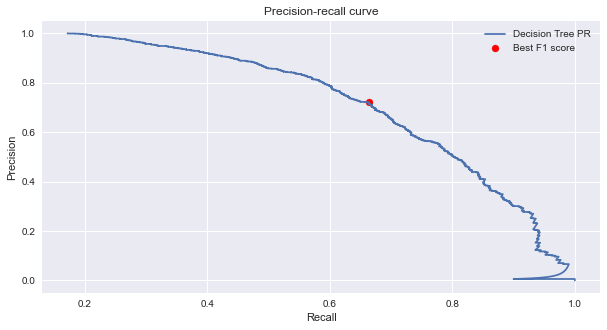

In [40]:
# Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
# Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='red', label='Best F1 score')
# Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend();

In [43]:
# Вероятность покупки > threshold_opt, относим к классу 1
#В противном случае — к классу 0
threshold_opt = thresholds[idx]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

